In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [2]:
df=pd.read_csv('./RNNDATA/daily_csv.csv')
df=df.dropna()
y=df['Price'].values
x=np.arange(1,len(y),1)
miny=y.min()
maxy=y.max()
y= (y-miny)/(maxy-miny)
print(df.count())
print(df.shape)

Date     5952
Price    5952
dtype: int64
(5952, 2)


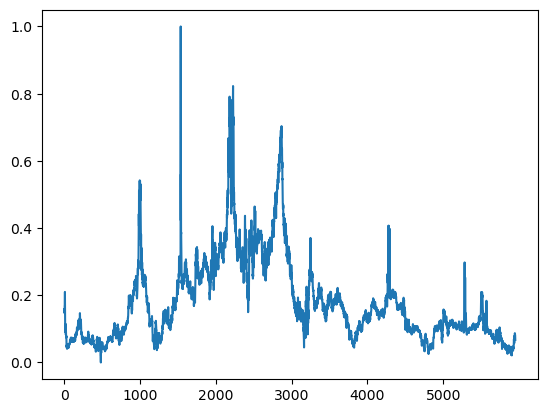

In [3]:
plt.plot(y)
plt.xticks(range(0,len(y),1000))
plt.show()

In [4]:
X=[]
Y=[]
seq_len=10
for i in range(0,len(y)-seq_len-1):
    x_seq=[]
    for j in range(i,i+seq_len):
        x_seq.append(y[j])
    X.append(x_seq)
    Y.append(y[j+1])
X=np.array(X)
Y=np.array(Y)

In [5]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,random_state=42,shuffle=False,stratify=None,test_size=0.1)

In [6]:
class NGTimeSeries(Dataset):
    def __init__(self,x,y):
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.float32)
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return len(self.x)

In [7]:
train_dataset=NGTimeSeries(x_train,y_train)
train_loader=DataLoader(train_dataset,shuffle=True,batch_size=256)
test_dataset=NGTimeSeries(x_test,y_test)
test_loader=DataLoader(test_dataset,shuffle=True,batch_size=256)

In [8]:
class RNN_model(nn.Module):
    def __init__(self):
        super(RNN_model,self).__init__()
        self.rnn=nn.RNN(input_size=1,hidden_size=5,num_layers=1,batch_first=True)
        self.fc=nn.Linear(5,1)
    def forward(self,x):
        output, _status=self.rnn(x)
        output=output[:, -1, :]
        output=self.fc(torch.relu(output))
        return output

In [9]:
model=RNN_model()

In [10]:
loss_func=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
epochs=1500

In [11]:
for i in range(1,epochs+1):
    loss_list=[]
    for j, data in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred=model(data[:][0].view(-1,seq_len,1)).reshape(-1)
        loss=loss_func(y_pred,data[:][1])
        loss.backward()
        optimizer.step()
    if i%100==0:
        print(i, "th iteration",loss)

100 th iteration tensor(0.0163, grad_fn=<MseLossBackward0>)
200 th iteration tensor(0.0002, grad_fn=<MseLossBackward0>)
300 th iteration tensor(0.0004, grad_fn=<MseLossBackward0>)
400 th iteration tensor(0.0013, grad_fn=<MseLossBackward0>)
500 th iteration tensor(0.0002, grad_fn=<MseLossBackward0>)
600 th iteration tensor(0.0002, grad_fn=<MseLossBackward0>)
700 th iteration tensor(0.0002, grad_fn=<MseLossBackward0>)
800 th iteration tensor(0.0002, grad_fn=<MseLossBackward0>)
900 th iteration tensor(0.0002, grad_fn=<MseLossBackward0>)
1000 th iteration tensor(0.0003, grad_fn=<MseLossBackward0>)
1100 th iteration tensor(0.0001, grad_fn=<MseLossBackward0>)
1200 th iteration tensor(0.0002, grad_fn=<MseLossBackward0>)
1300 th iteration tensor(0.0003, grad_fn=<MseLossBackward0>)
1400 th iteration tensor(0.0001, grad_fn=<MseLossBackward0>)
1500 th iteration tensor(0.0001, grad_fn=<MseLossBackward0>)


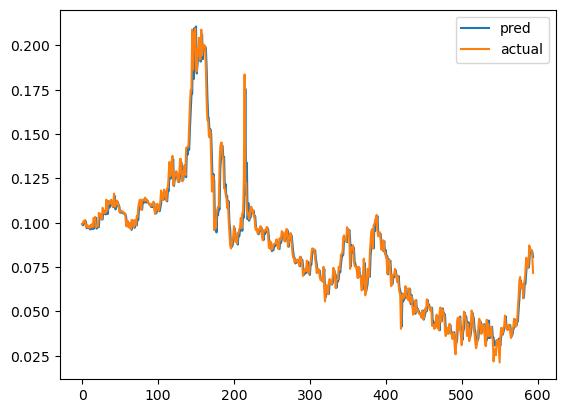

In [12]:
test_pred=model(test_dataset[:][0].view(-1,seq_len,1)).view(-1)
plt.plot(test_pred.detach().numpy(),label='pred')
plt.plot(test_dataset[:][1].view(-1),label='actual')
plt.legend()
plt.show()

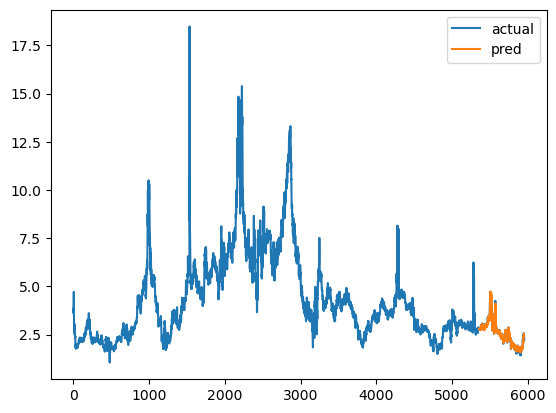

In [13]:
y=y*(maxy-miny)+miny
y_pred=test_pred.detach().numpy()*(maxy-miny)+miny
plt.plot(y,label='actual')
plt.plot(range(len(y)-len(y_pred),len(y)),y_pred,label='pred')
plt.legend()
plt.show()